In [35]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyro
import torch
import pyro.optim as optim
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, JitTrace_ELBO, Predictive
from pyro.distributions import constraints

# Single Level Model
In our simplest model, we will just model each post.

# Data

First, we load the Reddit datasets

In [36]:
comments = dict()
with open('../data/results/Comments.json') as f:
    for line in f:
        post = json.loads(line)
        comments[post['pid']] = post['api_num_comments'], post['comments']

In [37]:
corrections = []
with open('../data/results/CorrectionPairs.json') as f:
    for line in f:
        corrections.append(json.loads(line))

In [38]:
news = []
with open('../data/results/NewsPairs.json') as f:
    for line in f:
        news.append(json.loads(line))

Gather relevant variables

In [39]:
def processData(data, items, comments, minutes=60, offset=0):
    for idx, n in enumerate(items):
        i = idx + offset
        
        isNews = 'isFakeStory' in n['r']['reviewRating']
        news_id = n['p']['id']
        
        num_cmts, cmts = comments[news_id]
        c_body_lens = []
        c_ups = []
        c_downs = []
        unique_authors = set()
        for c in cmts:
            # skip if comment not created in first _ mins
            if c['delta_seconds'] > minutes * 60:
                continue

            c_minutes = c['delta_seconds'] / 60
            if c_minutes <= minutes:   # cmts in first _ mins
                data[i, 7] += 1
            
            c_body_lens.append(c['body_len'])
            c_ups.append(c['ups'])
            c_downs.append(c['downs'])
            
            if c['author']:
                unique_authors.add(c['author'])

        data[i, 0] = num_cmts
        if isNews:
            data[i, 1] = 1 if n['r']['reviewRating']['isFakeStory'] else 0
        else:
            data[i, 1] = 3 if n['r']['reviewRating']['isFakeClaim'] else 2
        data[i, 2] = np.mean(c_body_lens) if c_body_lens else 0.
        data[i, 3] = np.std(c_body_lens) if c_body_lens else 0.
        data[i, 4] = np.mean(c_ups) if c_ups else 0.
        data[i, 5] = np.std(c_ups) if c_ups else 0.
        data[i, 6] = len(unique_authors) if unique_authors else 0.
    return data

In [40]:
num_p_indep = 8
data = np.zeros((len(news) + len(corrections), num_p_indep))

data = processData(data, news, comments)
data = processData(data, corrections, comments, offset=len(news))

Variables (in order):

0. num_comments
1. type
2. comment_length_avg
3. comment_length_std
4. comment_upvotes_avg
5. comment_upvotes_std
6. num_unique_comment_authors
7. num_comments in first _ mins

In [41]:
p_data = data[:, (2,4,6,7)]  # avg cmt length, avg upvotes, num authors
t_data = data[:,1].reshape(-1,1)
biases = np.ones_like(t_data)

In [104]:
# select relevant indep vars
# p_data = data[:, (2,4,6,7)]  # avg cmt length, avg upvotes, num authors, num initial comments
p_data = data[:,7].reshape(-1,1)  # num comments in 1st hr
t_data = data[:,1].reshape(-1,1)

# add bias terms
biases = np.ones_like(t_data)
p_data = np.concatenate((biases, p_data), axis=1)
t_data = np.concatenate((biases, t_data), axis=1)

# get dep var
y = data[:,0].reshape(-1,1)

Subsample our data

In [105]:
p_data = p_data[:1000]
y = y[:1000]

split into train/test

In [106]:
train_frac = 0.7
num_obs = p_data.shape[0]
idx = np.random.binomial(1, train_frac, size=num_obs).astype(bool)

p_data_train = p_data[idx,:]
p_data_test = p_data[~idx,:]

y_train = y[idx,:]
y_test = y[~idx,:]

-----

# Modeling

Cast data to jax numpy arrays (immutable)

In [107]:
p_data_train = torch.Tensor(p_data_train)
p_data_test = torch.Tensor(p_data_test)
y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)

Post-Level Regression

y_p = phi_0 * bias + phi_1 * first_hour_comments + epsilon

In [108]:
def model(p_data, y):
    num_posts, num_p_indeps = p_data.shape

    # define a prior for our regression variables
    phi_prior = dist.Normal(torch.zeros((num_p_indeps, 1)),
                            10. * torch.ones((num_p_indeps, 1)))  # (num_p_indeps, 1)
    phi = pyro.sample("phi", phi_prior)  # (num_p_indeps, 1)
    
#    sigma_prior = dist.HalfNormal(1.)
#    sigma = numpyro.sample("sigma", sigma_prior)
    sigma = pyro.sample("sigma", dist.Uniform(0., 1000.))

    # for each post, use the correct set of coefficients to run our post-level regression
    with pyro.plate("post", num_posts, dim=-1) as p:

        # indep vars for this post
        indeps = p_data[p,:]  # (num_posts, num_p_indeps)
        
        # calculate the mean
        mu = torch.matmul(indeps, phi)  # (num_posts, num_p_indeps) (num_p_indeps, 1)
        
        # sample
        return pyro.sample("obs", dist.Normal(mu, sigma), obs=y[p])  # (num_posts, 1)

In [109]:
def guide(p_data, y):
    num_posts, num_p_indeps = p_data.shape
    
    phi_loc = pyro.param("phi_loc", torch.zeros((num_p_indeps, 1)))
    phi_scale = pyro.param("phi_scale", torch.ones((num_p_indeps, 1)), 
                              constraint=constraints.positive)
    
    #sigma_scale = numpyro.param("sigma_scale", 1.)
    sigma_loc = pyro.param('sigma_loc', torch.Tensor([1.]),
                             constraint=constraints.positive)
    
    # define a prior for our regression variables
    phi_prior = dist.Normal(phi_loc, phi_scale)  # (num_p_indeps, 1)
    phi = pyro.sample("phi", phi_prior)  # (num_p_indeps, 1)
    
#    sigma_prior = dist.HalfNormal(sigma_scale)
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.Tensor([0.05])))
#    sigma = numpyro.sample("sigma", sigma_prior)

# Inference

In [110]:
p_data[:100].shape

(100, 2)

In [111]:
svi = SVI(model,
          guide,
          optim.Adam({"lr": .1}),
          loss=JitTrace_ELBO())

pyro.clear_param_store()
num_iters = 1000
for i in range(num_iters):
    elbo = svi.step(p_data_train, y_train)
    if i % 50 == 0:
        print("Elbo loss: {}".format(elbo))

<ipython-input-109-1d8f2a47f64b>:9: TracerWarning: torch.Tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  sigma_loc = pyro.param('sigma_loc', torch.Tensor([1.]),
<ipython-input-109-1d8f2a47f64b>:17: TracerWarning: torch.Tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.Tensor([0.05])))


Elbo loss: 150550464.0
Elbo loss: 3273246.25
Elbo loss: 2504613.0
Elbo loss: 2257469.25
Elbo loss: 2189251.5
Elbo loss: 2186070.0
Elbo loss: 2181564.25
Elbo loss: 2083112.375
Elbo loss: 2155965.75
Elbo loss: 2103038.75
Elbo loss: 2130838.5
Elbo loss: 2049515.5
Elbo loss: 2073640.375
Elbo loss: 2044047.875
Elbo loss: 2055825.875
Elbo loss: 2046661.125
Elbo loss: 2066580.125
Elbo loss: 2031216.625
Elbo loss: 2063211.75
Elbo loss: 2042411.5


In [112]:
num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape((1,num_samples,-1)).detach().cpu().numpy()
               for k, v in predictive(p_data_test, y_test).items()
               if k != "obs"}

In [69]:
plt.plot(range(len(losses)), np.array(losses))
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

NameError: name 'losses' is not defined

In [83]:
params = svi.get_params(state)
params

AttributeError: 'SVI' object has no attribute 'get_params'

In [16]:
num_samples = 10
predictive = Predictive(model, guide=guide, params=params, num_samples=num_samples)
y_pred = predictive(rng_key, p_data=p_data_test, y=y_test)["obs"].copy()

In [17]:
for i in range(num_samples):
    if not np.alltrue(np.array(y_pred[0]) == np.array(y_test)):
        print(i)

In [18]:
y_pred[0]

array([[132.],
       [  0.],
       [  0.],
       ...,
       [ 10.],
       [  3.],
       [  0.]], dtype=float32)

In [19]:
y_test

DeviceArray([[132.],
             [  0.],
             [  0.],
             ...,
             [ 10.],
             [  3.],
             [  0.]], dtype=float32)

## some MCMC experiments

In [20]:
from numpyro.infer import MCMC, NUTS, Predictive

In [ ]:
kernel = NUTS(model)

num_iters = 1000
rng_key = PRNGKey(1)
mcmc = MCMC(kernel, num_warmup=500, num_samples=num_iters, num_chains=1, chain_method="parallel")
mcmc.run(rng_key, p_data_train, y_train)

warmup:   2%|▏         | 34/1500 [05:08<15:30:23, 38.08s/it, 255 steps of size 7.17e-10. acc. prob=0.54]

In [ ]:
posterior_samples = mcmc.get_samples()

In [61]:
numpyro.diagnostics.summary(posterior_samples)

NameError: name 'posterior_samples' is not defined

# Evaluation

Check the fit

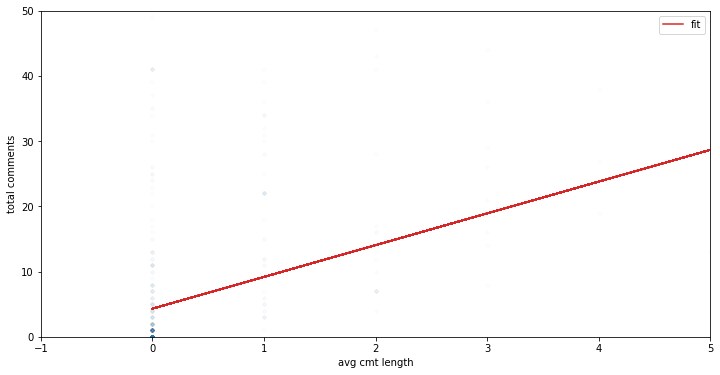

In [120]:
indep = 1

indep_dict = {
    1: "avg cmt length",
    2: "avg upvotes",
    3: "num authors",
    4: "comments in first hour",
}

y_pred = float(pyro.param('phi_loc').detach().numpy()[0])
y_pred += float(pyro.param('phi_loc').detach().numpy()[indep][0]) * p_data[:,indep]

plt.figure(figsize=(12,6))
plt.scatter(np.array(p_data[:,indep]), np.array(y), alpha=0.01, s=12, c='tab:blue')
plt.plot(np.array(p_data[:,indep]), np.array(y_pred), c='tab:red', label='fit')
plt.xlabel(indep_dict[indep])
plt.ylabel('total comments')
plt.xlim(-1,5)
plt.ylim(0,50)
plt.legend()
plt.show()

Interpretation:

- For posts with no comments in the first hour, we expect 7.23 comments in total
- For every comment in the first hour, we expect an additional 6.43 comments in total

Visualize the posterior predictive

In [70]:
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

In [21]:
num_samples = 1
predictive = Predictive(model, guide=guide, num_samples=num_samples)

In [22]:
# try this
predictive = Predictive(model, guide=guide, params=params, num_samples=num_samples)
samples = predictive(rng_key=rng_key, p_data=p_data, y=None)

In [30]:
samples['obs']

DeviceArray([[[ 1973.7627  ,  1150.6866  ,  -252.0852  , ...,
                -985.27985 ,   681.9505  ,  -315.42282 ],
              [  520.4189  ,   452.16684 , -1330.2083  , ...,
                1491.6713  , -1535.0989  ,  2169.3516  ],
              [  951.74866 ,   869.421   ,   598.5523  , ...,
                -203.42723 ,  -222.5085  ,   333.6607  ],
              ...,
              [-1205.326   ,   105.08023 ,   708.8266  , ...,
                 377.37637 , -2216.423   ,  1775.2568  ],
              [ -456.15738 ,    22.136986,  -433.57785 , ...,
                -595.1262  ,   316.51868 , -1021.9584  ],
              [ 1156.8049  ,  1656.196   ,   872.6163  , ...,
                -342.76154 ,   645.95953 ,   144.15564 ]]], dtype=float32)

In [33]:
svi_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(rng_key, p_data, None).items()
               if k != "obs"}

In [33]:
predictive = Predictive(svi, guide=guide, num_samples=1000)

# NUMPYRO EXPERIMENT END

----

In [76]:
import arviz as az
data = az.from_pyro(svi)
az.plot_trace(data, compact=False);

AttributeError: 'SVI' object has no attribute 'kernel'

In [79]:
az_samples = az.convert_to_inference_data(svi_samples)

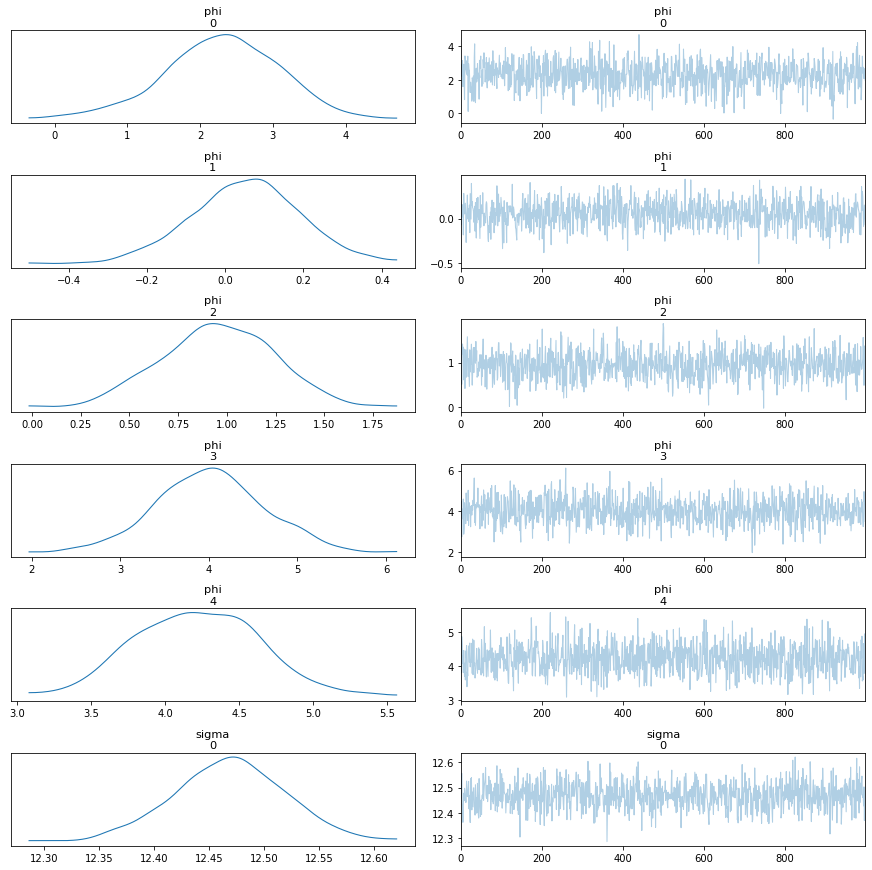

In [80]:
az.plot_trace(az_samples, compact=False);